## This note book gives the trend of multiple words in multiple mailing lists

What it does:
-it computes and plot word counts over time, on aggregated mailing lists' data.
-it exports emails that contains selected words 

Parameters to set options:
-it can track one or more words, according to the number of words set in the variable 'checkwords' 
-it can look in one or more mailing lists, according to how many urls are set; word counts are aggregated across mls
-it can look at literal words or at stemmed words, according to the 'stem' parameter

Useful extensions:
-export dictionary with wordcount trends on individual mailing lists
-look at compund words (e.g. 'human rights')
-give option to SUM word counts instead of treating words separately
-give possibility to normalize word counts

In [1]:
%matplotlib inline

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from bigbang.archive import load as load_archive
from bigbang.archive import Archive
import bigbang.mailman as mailman
import bigbang.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import numpy as np
import math
import nltk
from itertools import repeat
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from nltk.corpus import stopwords
import re

In [3]:
pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#insert a list of the urls of downloaded mailing lists that you want to include in the analysis. 
#data will be merged: multiple mailing lists are treated as a unique corpus
#e.g. urls  = ["https://mm.icann.org/pipermail/cc-humanrights/", 
#              "https://mm.icann.org/pipermail/euro-board/"]

urls = ["http://mm.icann.org/pipermail/cc-humanrights/",
              "http://mm.icann.org/pipermail/euro-board/"]
       #"http://mm.icann.org/pipermail/wp4/"]
#       "http://mm.icann.org/pipermail/wp1/"]



try:
    arch_paths =[]
    for url in urls:
        arch_paths.append('../archives/'+url[:-1].replace('://','_/')+'.csv')
    archives = [load_archive(arch_path) for arch_path in arch_paths]
except:
    arch_paths =[]
    for url in urls:
        arch_paths.append('../archives/'+url[:-1].replace('//','/')+'.csv')
        
archives = [load_archive(arch_path) for arch_path in arch_paths]

df = pd.concat([arx.data for arx in archives])

/home/sb/projects/nllz-bigbang/bigbang/bigbang/archive.py:73: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.data.sort(columns='Date', inplace=True)


In [5]:
#insert a list of *single* words to be tracked e.g. checkwords = ['rights', 'economy', 'human']
checkwords = ["internet","right","human","human rights"]

In [6]:
#to stem or not to stem? 
#if stem is set to True, then checkwords should be stemmed words (no plurals, no suffixes, etc.)
#if stem is set to False, then checkwords are searched for their literal spelling
stem = False

In [7]:
#extension: filter by date?

In [8]:
def count_word(text,word):
    if len(word.split(" ")) <= 1:
        ## normalize the text - remove apostrophe and punctuation, lower case
        normalized_text = re.sub(r'[^\w]', ' ',text.replace("'","")).lower()
    
        tokenized_text = nltk.tokenize.word_tokenize(normalized_text)

        if stem:
            tokenized_text = [st.stem(t) for t in tokenized_text]
    
        return tokenized_text.count(word)
    else:
        return text.lower().count(word)

In [9]:
for word in checkwords:
    df[word] = df['Body'].apply(lambda x: count_word(x,word))

In [10]:
#save each email in a file based on which checkword it contains. good for doing some qualitative analysis

#set the path where the data are to be saved
path = '.'

import os

for word in checkwords:
    print "Saving data for checkword "+word+"..."
    df[df[word] > 0].to_csv(os.path.join(path,word+'.csv'))

Saving data for checkword internet...
Saving data for checkword right...
Saving data for checkword human...
Saving data for checkword human rights...


In [11]:
df = df.dropna(subset=['Date'])
df['Date-ordinal'] = df['Date'].apply(lambda x: x.toordinal())

df_sums = df.groupby('Date-ordinal').sum()

In [12]:
from datetime import date

for_export = df_sums.copy()

dates_again = pd.Series(for_export.index,
                  index=for_export.index).apply(lambda x: 
                                                date.fromordinal(x))

for_export['Date'] = dates_again

for_export.to_csv("word_counts_by_date.csv")

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()


/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


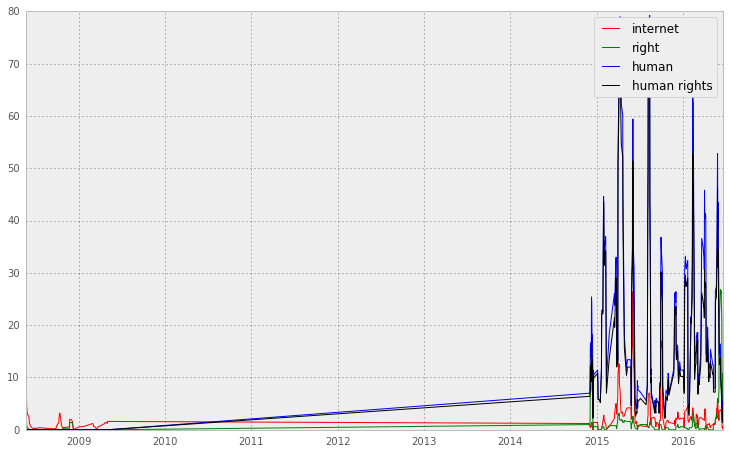

In [13]:
plt.figure(figsize=(12.5, 7.5))

colors = 'rgbkm'

window = 5

for i in range(len(checkwords)):
    smooth_sums = pd.rolling_mean(df_sums,window)
    
    plt.plot_date(smooth_sums.index,
                  smooth_sums[checkwords[i]],
                  colors[i],
                  label=checkwords[i])

plt.legend()